In [1]:
# file related
import os
from os.path import join
import datetime

# machine learning
from keras.models import Sequential
from keras.layers import Dense, Input
import tensorflow as tf
from sklearn.model_selection import train_test_split

# utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from IPython.display import Audio as play_audio
import scipy as sp
import taunet_utils
import json

# RTNeural special import
import sys
sys.path.append("../RTNeural/python/")
from model_utils import save_model

print(f"TF version {tf.__version__}")

TF version 2.12.0


In [2]:
with open(join("dataset", "saved", "AITD_Dataset_Kristof_beta_1in.json"), "r") as json_file:
    input_data = json.load(json_file)
with open(join("dataset", "saved", "AITD_Dataset_Kristof_beta_1out.json"), "r") as json_file:
    output_data = json.load(json_file)

for d in input_data:
    print(f"{d}: {input_data[d]} -> {output_data[d]}")

1 4397-spicy-drums: [0.7748, 0.012, 0.2251, 0.1621, 0.1335, 0.4836, 0.5895, 0.1336, 0.0194, 0.1007, 0.0475, 0.6738, 0.8758] -> [0.7210246, 0.3815809]
1 h_shift_96000_-1: [0.7748, 0.0262, 0.2208, 0.0786, 0.1709, 0.3627, 0.4122, 0.114, 0.0261, 0.1534, 0.0284, 0.6738, 0.8758] -> [0.7210246, 0.3815809]
1 ch_shift_96000_1: [0.7748, 0.026, 0.2163, 0.0884, 0.2598, 0.2331, 0.286, 0.0802, 0.0215, 0.1594, 0.0343, 0.6738, 0.8758] -> [0.7210246, 0.3815809]
1 s_time_fade_1_in: [0.7748, 0.014, 0.2246, 0.1826, 0.2913, 0.4839, 0.5903, 0.1342, 0.0194, 0.0983, 0.0, 0.6738, 0.8758] -> [0.7210246, 0.3815809]
1 _time_fade_1_out: [0.7769, 0.014, 0.2276, 0.0918, 0.0815, 0.5813, 0.6499, 0.2184, 0.0448, 0.0998, 0.0368, 0.6738, 0.8758] -> [0.7210246, 0.3815809]
1 time_offset_-0_5: [0.7748, 0.014, 0.2246, 0.1827, 0.3236, 0.5296, 0.5921, 0.1342, 0.0194, 0.0998, 0.1073, 0.6738, 0.8758] -> [0.7210246, 0.3815809]
1 time_offset_-1_0: [0.7748, 0.014, 0.2246, 0.1545, 0.2215, 0.5299, 0.6201, 0.1342, 0.0111, 0.0977, 0.00

In [3]:
def create_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    # model.add(layers.LSTM(64, return_sequences=True))   # short term memory, useful if input data is related accross vectors
    model.add(Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.001))) # no activation (linear): continuous mapping of outputs (this is not a classification task!)
    return model

input_shape = (13,)
model = create_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 4)                 36        
                                                                 
 dense_6 (Dense)             (None, 2)                 1

In [4]:
combined_data = [(input_data[key], output_data[key]) for key in input_data.keys()]

train_data, test_data = train_test_split(combined_data, test_size=0.05, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class LogRMSECallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir):
        super(LogRMSECallback, self).__init__()
        self.log_dir = log_dir

    def on_epoch_end(self, epoch, logs=None):
        mse = logs.get('val_loss')
        rmse = np.sqrt(mse)
        with tf.summary.create_file_writer(self.log_dir).as_default():
            tf.summary.scalar('val_rmse', rmse, step=epoch)

%load_ext tensorboard
%tensorboard --logdir logs/ --port 6006

history = model.fit(
    x=np.array([item[0] for item in train_data]),
    y=np.array([item[1] for item in train_data]),
    validation_data=(
        np.array([item[0] for item in val_data]),
        np.array([item[1] for item in val_data])
    ),
    epochs=50,
    # callbacks=[tensorboard_callback, early_stopping_callback],
    callbacks=[tensorboard_callback, early_stopping_callback, LogRMSECallback(join(log_dir, "rmse"))],
    # batch_size=16
)

Reusing TensorBoard on port 6006 (pid 11700), started 13 days, 21:56:03 ago. (Use '!kill 11700' to kill it.)

Epoch 1/50
19/19 [==============================] - 3s 38ms/step - loss: 0.1964 - accuracy: 0.3744 - val_loss: 0.1274 - val_accuracy: 0.3517
Epoch 2/50
19/19 [==============================] - 0s 13ms/step - loss: 0.1083 - accuracy: 0.3744 - val_loss: 0.0933 - val_accuracy: 0.3517
Epoch 3/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0879 - accuracy: 0.3951 - val_loss: 0.0821 - val_accuracy: 0.6483
Epoch 4/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0802 - accuracy: 0.6256 - val_loss: 0.0758 - val_accuracy: 0.6483
Epoch 5/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0770 - accuracy: 0.6256 - val_loss: 0.0744 - val_accuracy: 0.6483
Epoch 6/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0757 - accuracy: 0.6256 - val_loss: 0.0739 - val_accuracy: 0.6483
Epoch 7/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0748 - accuracy: 0.6256 - val_loss: 0.0730 - val_accuracy: 0.6483
Epoch 8/50
19

In [9]:
train_metrics = model.evaluate(
    np.array([item[0] for item in train_data]),
    np.array([item[1] for item in train_data]),
    verbose=0
)
val_metrics = model.evaluate(
    np.array([item[0] for item in val_data]),
    np.array([item[1] for item in val_data]),
    verbose=0
)
test_metrics = model.evaluate(
    np.array([item[0] for item in test_data]), 
    np.array([item[1] for item in test_data]),
    verbose=0
)

zero_return = model.predict((([0] * 13),))

for item in test_data:
    inp = np.array([item[0]])  # Reshape input data into a batch
    prediction = model.predict(inp)
    print("Input:", item[0])
    print("Expected Output:", item[1])
    print("Predicted Output:", prediction[0])


print({f"Train {metric_name}": metric_value for metric_name, metric_value in zip(model.metrics_names, train_metrics)})
print({f"Validation {metric_name}": metric_value for metric_name, metric_value in zip(model.metrics_names, val_metrics)})
print({f"Test {metric_name}": metric_value for metric_name, metric_value in zip(model.metrics_names, test_metrics)})
print("RMSE for test set:", np.sqrt(test_metrics[0]))
print(f"Zero return constants: {zero_return}")

# save model as .h5, .tflite and .json
model.save(join(log_dir, "taunet.pb"))
tflite_model = tf.lite.TFLiteConverter.from_saved_model(join(log_dir, "taunet.pb")).convert()
with open(join(log_dir, "taunet.tflite"), 'wb') as f:
  f.write(tflite_model)
save_model(model, join(log_dir, "taunet.json"))

1/1 [==============================] - 0s 27ms/step
Input: [0.5208, 0.0182, 0.1626, 0.0653, 0.1851, 0.5757, 0.2079, 0.1383, 0.015, 0.0414, 0.0, 0.5916, 0.324]
Expected Output: [0.9999752, 0.5807066]
Predicted Output: [0.9222278 0.3703438]
1/1 [==============================] - 0s 31ms/step
Input: [0.5493, 0.0241, 0.1759, 0.0811, 0.0916, 0.4779, 0.2418, 0.0958, 0.0284, 0.0327, 0.0606, 0.7254, 0.55]
Expected Output: [0.9453346, 0.14960826666666666]
Predicted Output: [0.98625433 0.28086284]
1/1 [==============================] - 0s 27ms/step
Input: [0.6222, 0.025, 0.1914, 0.0385, 0.1105, 0.6825, 0.2988, 0.0794, 0.0226, 0.0306, 0.0467, 0.6357, 0.3034]
Expected Output: [0.9407981999999999, 0.07256796666666666]
Predicted Output: [0.99052125 0.328915  ]
1/1 [==============================] - 0s 29ms/step
Input: [0.8321, 0.0379, 0.1443, 0.0498, 0.1728, 0.6613, 0.2634, 0.0747, 0.0195, 0.0297, 0.0454, 0.7667, 0.9138]
Expected Output: [0.203009, 0.2766109]
Predicted Output: [0.43507922 0.39097726

INFO:tensorflow:Assets written to: logs/20240509-134449\taunet.pb\assets


INFO:tensorflow:Assets written to: logs/20240509-134449\taunet.pb\assets


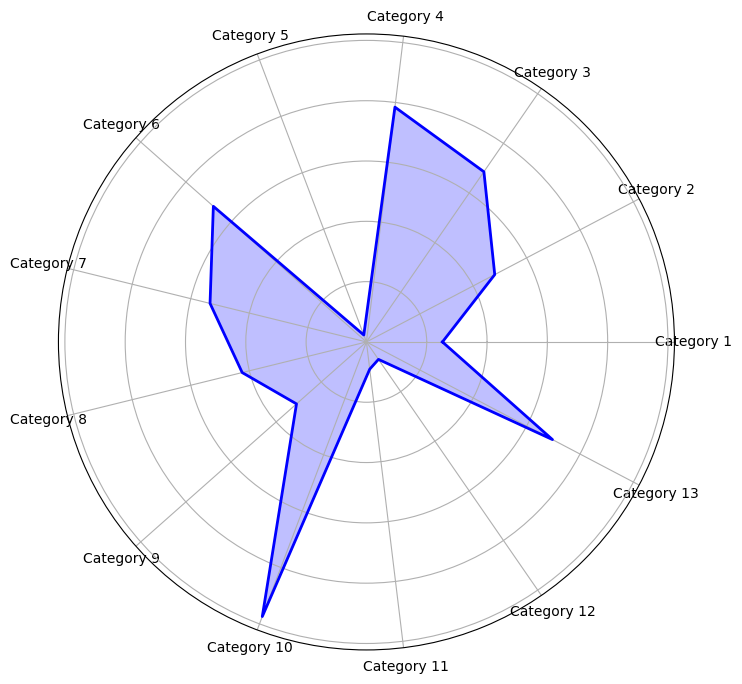

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def spiderweb_plot(data, categories):
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    data = np.concatenate((data, [data[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    ax.fill(angles, data, color='blue', alpha=0.25)
    ax.plot(angles, data, color='blue', linewidth=2)
    
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    
    plt.show()

# Example data and categories
data = np.random.rand(13) * 10  # Example data
categories = [f'Category {i+1}' for i in range(13)]  # Example categories

# Create spiderweb plot
spiderweb_plot(data, categories)
